In [1]:
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 67.8 MB/s eta 0:00:00


In [ ]:
import os
import time
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from jiwer import wer, cer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pickle
import re
import math

In [3]:
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [4]:
# Check if GPU is available
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {DEVICE}')

Using device: cuda


In [5]:
# Create output directory
from google.colab import drive
drive.mount('/content/drive')

OUTPUT_DIR = '/content/drive/MyDrive/output_transformer_word/'
os.makedirs(OUTPUT_DIR, exist_ok=True)

Mounted at /content/drive


In [ ]:
# # Create output directory
# OUTPUT_DIR = './output_transformer_word/'
# if not os.path.exists(OUTPUT_DIR):
#     os.makedirs(OUTPUT_DIR)

In [ ]:
# Paths for saving/loading
DATASET_PATH = './exportStatements.xlsx'
VOCAB_PATH = os.path.join(OUTPUT_DIR, 'word_vocab.pkl')
PREPROCESSED_DATA_PATH = os.path.join(OUTPUT_DIR, 'preprocessed_data_word.pkl')
BEST_MODEL_PATH = os.path.join(OUTPUT_DIR, 'best_transformer_model_word.pt')
BEST_CER_MODEL_PATH = os.path.join(OUTPUT_DIR, 'best_transformer_model_cer.pt')
LOSS_PLOT_PATH = os.path.join(OUTPUT_DIR, 'transformer_loss_plot_char.png')
ER_PLOT_PATH = os.path.join(OUTPUT_DIR, 'er_plot.png')

In [10]:
# Load the dataset
df = pd.read_excel(DATASET_PATH)

In [11]:
# Check for missing values in 'inFormalForm' and 'FormalForm'
print("Missing values in 'inFormalForm':", df['inFormalForm'].isnull().sum())
print("Missing values in 'FormalForm':", df['FormalForm'].isnull().sum())

# Drop rows with missing values in 'inFormalForm' and 'FormalForm'
initial_length = len(df)
df = df.dropna(subset=['inFormalForm', 'FormalForm']).reset_index(drop=True)
final_length = len(df)

df['inFormalForm'] = df['inFormalForm'].astype(str)
df['FormalForm'] = df['FormalForm'].astype(str)

print(f"Dropped {initial_length - final_length} rows due to missing values.")

Missing values in 'inFormalForm': 0
Missing values in 'FormalForm': 1
Dropped 1 rows due to missing values.


In [12]:
def clean_persian_text(text):
    # 1. Keep only Persian letters, English letters, digits, whitespace, ZWNJ
    text = re.sub(r"[^\u0600-\u06FFa-zA-Z0-9\u06F0-\u06F9\u0660-\u0669\u200c\s]", " ", text)
    # Remove leftover Persian punctuations explicitly (، ؛ ؟)
    text = re.sub(r"[،؛؟]", " ", text)
    # Remove Arabic diacritics (harakat)
    arabic_diacritics = r"[\u064B-\u065F\u0670\u06D6-\u06ED]"
    text = re.sub(arabic_diacritics, "", text)

    # 2. Normalize Persian/Arabic digits to Western digits
    persian_digits = "۰۱۲۳۴۵۶۷۸۹"
    arabic_digits = "٠١٢٣٤٥٦٧٨٩"
    for p, a, e in zip(persian_digits, arabic_digits, "0123456789"):
        text = text.replace(p, e).replace(a, e)

    # 3. Separate numbers stuck to Persian/English letters
    text = re.sub(r"(\d+)(?=[\u0600-\u06FFa-zA-Z])", r"\1 ", text)  # digit before letter
    text = re.sub(r"([\u0600-\u06FFa-zA-Z])(?=\d+)", r"\1 ", text)  # letter before digit

    # 4. Remove underscores
    text = re.sub(r"_+", "", text)

    # 5. Normalize spaces
    text = re.sub(r"\s+", " ", text).strip()

    return text

In [13]:
df['inFormalForm'] = df['inFormalForm'].apply(clean_persian_text)
df['FormalForm'] = df['FormalForm'].apply(clean_persian_text)

In [14]:
# Split data into training, validation, and test sets (80%, 10%, 10%)
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=SEED)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=SEED)

In [ ]:
# Simple tokenizer function
def tokenize(text):
    # Split on whitespace and punctuation
    token_pattern = r'\w+|[^\s\w]+'
    tokens = re.findall(token_pattern, text)

    return tokens

In [16]:
# Build word vocabulary from training data
if not os.path.exists(VOCAB_PATH):
    print('Building word vocabulary...')
    from collections import Counter

    # Collect all words from the training data
    all_words = []
    for text in train_df['inFormalForm'].tolist() + train_df['FormalForm'].tolist():
        tokens = tokenize(text)
        all_words.extend(tokens)

    # Build vocabulary
    word_counts = Counter(all_words)
    words = sorted(word_counts.keys())

    # Add special tokens
    special_tokens = ['<pad>', '<unk>', '<s>', '</s>']
    word2idx = {word: idx + len(special_tokens) for idx, word in enumerate(words)}
    for idx, token in enumerate(special_tokens):
        word2idx[token] = idx
    idx2word = {idx: word for word, idx in word2idx.items()}

    # Save vocabulary
    with open(VOCAB_PATH, 'wb') as f:
        pickle.dump({'word2idx': word2idx, 'idx2word': idx2word}, f)
    print('Word vocabulary built and saved.')
else:
    print('Loading existing word vocabulary...')
    with open(VOCAB_PATH, 'rb') as f:
        vocab = pickle.load(f)
        word2idx = vocab['word2idx']
        idx2word = vocab['idx2word']

Building word vocabulary...
Word vocabulary built and saved.


In [17]:
# Special token IDs
PAD_IDX = word2idx['<pad>']
UNK_IDX = word2idx['<unk>']
BOS_IDX = word2idx['<s>']
EOS_IDX = word2idx['</s>']

PAD_IDX, UNK_IDX, BOS_IDX, EOS_IDX

(0, 1, 2, 3)

In [18]:
# Maximum sequence length (based on dataset)
def get_max_len(df_list):
    max_len = 0
    for df in df_list:
        lengths_src = df['inFormalForm'].apply(lambda x: len(tokenize(x)) + 2)  # +2 for BOS and EOS
        lengths_trg = df['FormalForm'].apply(lambda x: len(tokenize(x)) + 2)
        max_len = max(max_len, lengths_src.max(), lengths_trg.max())
    return max_len

MAX_LEN = get_max_len([train_df, val_df, test_df])

MAX_LEN

108

In [19]:
# Check if preprocessed data exists
if not os.path.exists(PREPROCESSED_DATA_PATH):
    print('Preprocessing data...')
    # Preprocess and tokenize all sentences
    def preprocess_data(df, word2idx, max_len=MAX_LEN):
        src_texts = df['inFormalForm'].tolist()
        trg_texts = df['FormalForm'].tolist()
        src_sequences = []
        trg_sequences = []
        for src, trg in zip(src_texts, trg_texts):
            src_tokens = tokenize(src)
            trg_tokens = tokenize(trg)
            src_ids = [BOS_IDX] + [word2idx.get(w, UNK_IDX) for w in src_tokens] + [EOS_IDX]
            trg_ids = [BOS_IDX] + [word2idx.get(w, UNK_IDX) for w in trg_tokens] + [EOS_IDX]
            # Pad or truncate sequences
            src_ids = src_ids[:max_len] + [PAD_IDX] * max(0, max_len - len(src_ids))
            trg_ids = trg_ids[:max_len] + [PAD_IDX] * max(0, max_len - len(trg_ids))
            src_sequences.append(src_ids)
            trg_sequences.append(trg_ids)
        return src_sequences, trg_sequences

    # Tokenize and preprocess data
    train_src, train_trg = preprocess_data(train_df, word2idx)
    val_src, val_trg = preprocess_data(val_df, word2idx)
    test_src, test_trg = preprocess_data(test_df, word2idx)

    # Save preprocessed data
    with open(PREPROCESSED_DATA_PATH, 'wb') as f:
        pickle.dump({
            'train_src': train_src,
            'train_trg': train_trg,
            'val_src': val_src,
            'val_trg': val_trg,
            'test_src': test_src,
            'test_trg': test_trg,
            'MAX_LEN': MAX_LEN
        }, f)
    print('Preprocessed data saved.')
else:
    print('Loading preprocessed data...')
    # Load preprocessed data
    with open(PREPROCESSED_DATA_PATH, 'rb') as f:
        data = pickle.load(f)
        train_src = data['train_src']
        train_trg = data['train_trg']
        val_src = data['val_src']
        val_trg = data['val_trg']
        test_src = data['test_src']
        test_trg = data['test_trg']
        MAX_LEN = data['MAX_LEN']

Preprocessing data...
Preprocessed data saved.


In [20]:
# Prepare datasets
class TranslationDataset(Dataset):
    def __init__(self, src_sequences, trg_sequences):
        self.src_sequences = src_sequences
        self.trg_sequences = trg_sequences

    def __len__(self):
        return len(self.src_sequences)

    def __getitem__(self, idx):
        src_ids = torch.tensor(self.src_sequences[idx], dtype=torch.long)
        trg_ids = torch.tensor(self.trg_sequences[idx], dtype=torch.long)
        return src_ids, trg_ids

In [21]:
# Collate function to create masks and pad sequences
def collate_fn(batch, pad_idx):
    src_batch, trg_batch = zip(*batch)
    src_batch = torch.nn.utils.rnn.pad_sequence(src_batch, padding_value=pad_idx, batch_first=True)
    trg_batch = torch.nn.utils.rnn.pad_sequence(trg_batch, padding_value=pad_idx, batch_first=True)
    return src_batch, trg_batch

In [ ]:
# Create datasets and dataloaders
batch_size = 32

train_dataset = TranslationDataset(train_src, train_trg)
val_dataset = TranslationDataset(val_src, val_trg)
test_dataset = TranslationDataset(test_src, test_trg)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: collate_fn(x, PAD_IDX))
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=lambda x: collate_fn(x, PAD_IDX))
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=lambda x: collate_fn(x, PAD_IDX))

In [ ]:
# Function to generate subsequent masks for target
def generate_square_subsequent_mask(sz):
    mask = torch.triu(torch.ones((sz, sz), device=DEVICE), diagonal=1).bool()
    return mask.float().masked_fill(mask, float('-inf'))

In [ ]:
# Function to create padding masks
def create_mask(src, tgt, pad_idx):
    src_seq_len = src.size(1)
    tgt_seq_len = tgt.size(1)

    src_mask = torch.zeros((src_seq_len, src_seq_len), device=DEVICE).float()
    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)

    src_padding_mask = (src == pad_idx)
    tgt_padding_mask = (tgt == pad_idx)

    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [ ]:
# Transformer Model Definition
class Seq2SeqTransformer(nn.Module):
    def __init__(self, num_encoder_layers, num_decoder_layers, emb_size,
                 nhead, src_vocab_size, tgt_vocab_size, dim_feedforward=512,
                 dropout=0.1, max_len=MAX_LEN, pad_idx=PAD_IDX):
        super(Seq2SeqTransformer, self).__init__()
        self.src_vocab_size = src_vocab_size
        self.tgt_vocab_size = tgt_vocab_size
        self.emb_size = emb_size
        self.pad_idx = pad_idx
        self.max_len = max_len

        # Token embedding layers
        self.src_embedding = nn.Embedding(src_vocab_size, emb_size, padding_idx=pad_idx)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, emb_size, padding_idx=pad_idx)

        # Learned positional embeddings
        self.src_pos_embedding = nn.Embedding(max_len, emb_size)
        self.tgt_pos_embedding = nn.Embedding(max_len, emb_size)

        # Transformer
        self.transformer = nn.Transformer(d_model=emb_size, nhead=nhead,
                                          num_encoder_layers=num_encoder_layers,
                                          num_decoder_layers=num_decoder_layers,
                                          dim_feedforward=dim_feedforward,
                                          dropout=dropout)

        # Output layer
        self.generator = nn.Linear(emb_size, tgt_vocab_size)

    def forward(self, src, tgt, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, memory_key_padding_mask):
        # src and tgt shape: [batch_size, seq_len]
        src_seq_len = src.size(1)
        tgt_seq_len = tgt.size(1)
        src_positions = torch.arange(0, src_seq_len, device=src.device).unsqueeze(0).expand(src.size(0), -1)
        tgt_positions = torch.arange(0, tgt_seq_len, device=tgt.device).unsqueeze(0).expand(tgt.size(0), -1)


        # Embed and encode source
        src_tok = self.src_embedding(src) * math.sqrt(self.emb_size)
        src_emb = src_tok + self.src_pos_embedding(src_positions)

        # Embed and encode target
        tgt_tok = self.tgt_embedding(tgt) * math.sqrt(self.emb_size)
        tgt_emb = tgt_tok + self.tgt_pos_embedding(tgt_positions)

        # Transformer
        output = self.transformer(
            src_emb.transpose(0, 1), tgt_emb.transpose(0, 1),
            src_mask=src_mask, tgt_mask=tgt_mask, memory_mask=None,
            src_key_padding_mask=src_padding_mask,
            tgt_key_padding_mask=tgt_padding_mask,
            memory_key_padding_mask=memory_key_padding_mask
        )

        output = output.transpose(0,1)
        logits = self.generator(output)
        return logits

    def encode(self, src, src_mask, src_key_padding_mask=None):
        src_seq_len = src.size(1)
        src_positions = torch.arange(0, src_seq_len, device=src.device).unsqueeze(0).expand(src.size(0), -1)
        src_tok = self.src_embedding(src) * math.sqrt(self.emb_size)
        src_emb = src_tok + self.src_pos_embedding(src_positions)
        return self.transformer.encoder(
            src_emb.transpose(0, 1),
            mask=src_mask,
            src_key_padding_mask=src_key_padding_mask
        )

    def decode(self, tgt, memory, tgt_mask, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        tgt_seq_len = tgt.size(1)
        tgt_positions = torch.arange(0, tgt_seq_len, device=tgt.device).unsqueeze(0).expand(tgt.size(0), -1)
        tgt_tok = self.tgt_embedding(tgt) * math.sqrt(self.emb_size)
        tgt_emb = tgt_tok + self.tgt_pos_embedding(tgt_positions)
        return self.transformer.decoder(
            tgt_emb.transpose(0, 1), memory,
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
            memory_key_padding_mask=memory_key_padding_mask
        )

In [ ]:
# Initialize model parameters
VOCAB_SIZE = len(word2idx)
SRC_VOCAB_SIZE = VOCAB_SIZE
TGT_VOCAB_SIZE = VOCAB_SIZE

# Hyperparameters
num_encoder_layers = 3
num_decoder_layers = 3
emb_size = 256
nhead = 8
dim_feedforward = 256
dropout = 0.1


model = Seq2SeqTransformer(num_encoder_layers, num_decoder_layers, emb_size,
                           nhead, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE,
                           dim_feedforward, dropout, MAX_LEN, PAD_IDX).to(DEVICE)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [ ]:
# Initialize optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [ ]:
def detokenize(ids, idx2word):
    toks = [idx2word.get(i, '') for i in ids if i not in (PAD_IDX, BOS_IDX, EOS_IDX)]
    s = ""
    for t in toks:
        if len(t) == 1 and t is "\u200c":
            s += t
        elif s == "":
            s += t
        else:
            s += " " + t
    return s.strip()

<>:5: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:5: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
/tmp/ipython-input-3816964553.py:5: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  if len(t) == 1 and t is "\u200c":


In [ ]:
@torch.no_grad()
def greedy_decode_train(model, src, pad_idx, bos_idx, eos_idx, max_len):
    model.eval()
    device = src.device
    # masks
    src_seq_len = src.size(1)
    src_mask = torch.zeros((src_seq_len, src_seq_len), device=device).float()
    src_padding_mask = (src == pad_idx)

    # encode
    memory = model.encode(src, src_mask, src_key_padding_mask=src_padding_mask)

    # start with BOS
    ys = torch.full((src.size(0), 1), bos_idx, dtype=torch.long, device=device)

    for _ in range(max_len - 1):
        tgt_mask = generate_square_subsequent_mask(ys.size(1)).to(device)
        out = model.decode(
            ys, memory, tgt_mask,
            tgt_key_padding_mask=None,
            memory_key_padding_mask=src_padding_mask
        )  # shape: (tgt_len, batch, emb)
        out = out.transpose(0, 1)                       # (batch, tgt_len, emb)
        logits = model.generator(out[:, -1, :])         # (batch, vocab)
        next_token = logits.argmax(dim=-1, keepdim=True)  # (batch, 1)
        ys = torch.cat([ys, next_token], dim=1)
        if (next_token.squeeze(1) == eos_idx).all():
            break

    return ys  # (batch, decoded_len)

In [ ]:
def evaluate_wer(model, dataloader, idx2word, max_batches=None):
    model.eval()
    cer_scores = []
    wer_scores = []
    batches = 0
    with torch.no_grad():
        for src, trg in dataloader:
            src = src.to(DEVICE)
            trg = trg.to(DEVICE)
            preds = greedy_decode_train(model, src, PAD_IDX, BOS_IDX, EOS_IDX, MAX_LEN)

            # strip BOS for text
            pred_ids = preds[:, 1:].tolist()
            gold_ids = trg[:, 1:].tolist()

            for p_ids, g_ids in zip(pred_ids, gold_ids):
                pred_sentence = detokenize(p_ids, idx2word)
                gold_sentence = detokenize(g_ids, idx2word)
                cer_scores.append(cer(gold_sentence, pred_sentence))
                wer_scores.append(wer(gold_sentence, pred_sentence))

            batches += 1
            if max_batches and batches >= max_batches:
                break

    return float(np.mean(cer_scores)), float(np.mean(wer_scores))

In [ ]:
# Training loop with WER calculation
N_EPOCHS = 100
best_valid_loss = float('inf')
best_valid_cer = float('inf')
patience = 5
counter = 0

train_losses = []
valid_losses = []

train_wers = []
valid_wers = []
train_cers = []
valid_cers = []

for epoch in range(1, N_EPOCHS + 1):
    start_time = time.time()

    # Training
    model.train()
    epoch_train_loss = 0
    for src, trg in tqdm(train_loader, desc=f'Training Epoch {epoch}/{N_EPOCHS}'):
        src = src.to(DEVICE)
        trg = trg.to(DEVICE)

        # Create masks
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, trg[:, :-1], PAD_IDX)

        optimizer.zero_grad()
        output = model(src, trg[:, :-1], src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)

        trg_out = trg[:, 1:]

        output = output.reshape(-1, TGT_VOCAB_SIZE)
        trg_out = trg_out.reshape(-1)

        loss = criterion(output, trg_out)
        loss.backward()

        optimizer.step()

        epoch_train_loss += loss.item()

    epoch_train_loss /= len(train_loader)
    train_losses.append(epoch_train_loss)


    # Validation
    model.eval()
    epoch_valid_loss = 0
    with torch.no_grad():
        for src, trg in tqdm(val_loader, desc=f'Validation Epoch {epoch}/{N_EPOCHS}'):
            src = src.to(DEVICE)
            trg = trg.to(DEVICE)

            src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, trg[:, :-1], PAD_IDX)

            output = model(src, trg[:, :-1], src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)

            trg_out = trg[:, 1:]

            output = output.reshape(-1, TGT_VOCAB_SIZE)
            trg_out = trg_out.reshape(-1)

            loss = criterion(output, trg_out)
            epoch_valid_loss += loss.item()

    epoch_valid_loss /= len(val_loader)
    valid_losses.append(epoch_valid_loss)

    # Evaluate WER
    valid_cer, valid_wer = evaluate_wer(model, val_loader, idx2word)
    valid_wers.append(valid_wer)
    valid_cers.append(valid_cer)

    print(f'\tTrain Loss: {epoch_train_loss:.3f}')
    print(f'\tValid Loss: {epoch_valid_loss:.3f}')
    print(f'\tValid WER: {valid_wer:.4f}')
    print(f'\tValid CER: {valid_cer:.4f}')

    # Early stopping check
    if epoch_valid_loss < best_valid_loss:
        best_valid_loss = epoch_valid_loss
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print(f'Validation loss improved. Model saved to {BEST_MODEL_PATH}.')
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print('Early stopping triggered.')
            break

    if valid_cer < best_valid_cer:
        best_valid_cer = valid_cer
        torch.save(model.state_dict(), BEST_CER_MODEL_PATH)
        print(f'Validation CER improved. Model saved to {BEST_CER_MODEL_PATH}.')

    end_time = time.time()
    epoch_mins, epoch_secs = divmod(int(end_time - start_time), 60)

    print(f'Epoch: {epoch:02} | Time: {epoch_mins}m {epoch_secs}s')

Training Epoch 1/100:   0%|          | 0/1251 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6041: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6041: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
Validation Epoch 1/100: 100%|██████████| 157/157 [00:08<00:00, 17.95it/s]


	Train Loss: 5.297
	Valid Loss: 4.572
	Valid WER: 1.1538
	Valid CER: 0.8373
Validation loss improved. Model saved to /content/drive/MyDrive/output_transformer_word/best_transformer_model_word.pt.
Validation CER improved. Model saved to /content/drive/MyDrive/output_transformer_word/best_transformer_model_cer.pt.
Epoch: 01 | Time: 4m 44s


Validation Epoch 2/100: 100%|██████████| 157/157 [00:08<00:00, 17.92it/s]


	Train Loss: 4.247
	Valid Loss: 3.949
	Valid WER: 1.7670
	Valid CER: 1.4063
Validation loss improved. Model saved to /content/drive/MyDrive/output_transformer_word/best_transformer_model_word.pt.
Epoch: 02 | Time: 5m 0s


Validation Epoch 3/100: 100%|██████████| 157/157 [00:08<00:00, 17.83it/s]


	Train Loss: 3.621
	Valid Loss: 3.532
	Valid WER: 2.5011
	Valid CER: 2.1625
Validation loss improved. Model saved to /content/drive/MyDrive/output_transformer_word/best_transformer_model_word.pt.
Epoch: 03 | Time: 5m 17s


Validation Epoch 4/100: 100%|██████████| 157/157 [00:08<00:00, 17.85it/s]


	Train Loss: 3.093
	Valid Loss: 3.215
	Valid WER: 2.3897
	Valid CER: 2.0808
Validation loss improved. Model saved to /content/drive/MyDrive/output_transformer_word/best_transformer_model_word.pt.
Epoch: 04 | Time: 5m 16s


Validation Epoch 5/100: 100%|██████████| 157/157 [00:08<00:00, 17.88it/s]


	Train Loss: 2.643
	Valid Loss: 2.991
	Valid WER: 1.8667
	Valid CER: 1.6480
Validation loss improved. Model saved to /content/drive/MyDrive/output_transformer_word/best_transformer_model_word.pt.
Epoch: 05 | Time: 5m 5s


Validation Epoch 6/100: 100%|██████████| 157/157 [00:08<00:00, 17.86it/s]


	Train Loss: 2.250
	Valid Loss: 2.850
	Valid WER: 0.9876
	Valid CER: 0.8152
Validation loss improved. Model saved to /content/drive/MyDrive/output_transformer_word/best_transformer_model_word.pt.
Validation CER improved. Model saved to /content/drive/MyDrive/output_transformer_word/best_transformer_model_cer.pt.
Epoch: 06 | Time: 4m 25s


Validation Epoch 7/100: 100%|██████████| 157/157 [00:08<00:00, 17.93it/s]


	Train Loss: 1.909
	Valid Loss: 2.677
	Valid WER: 1.7619
	Valid CER: 1.5592
Validation loss improved. Model saved to /content/drive/MyDrive/output_transformer_word/best_transformer_model_word.pt.
Epoch: 07 | Time: 5m 0s


Validation Epoch 8/100: 100%|██████████| 157/157 [00:08<00:00, 17.80it/s]


	Train Loss: 1.620
	Valid Loss: 2.596
	Valid WER: 2.2703
	Valid CER: 2.0805
Validation loss improved. Model saved to /content/drive/MyDrive/output_transformer_word/best_transformer_model_word.pt.
Epoch: 08 | Time: 5m 12s


Validation Epoch 9/100: 100%|██████████| 157/157 [00:08<00:00, 17.85it/s]


	Train Loss: 1.386
	Valid Loss: 2.514
	Valid WER: 1.1262
	Valid CER: 0.9618
Validation loss improved. Model saved to /content/drive/MyDrive/output_transformer_word/best_transformer_model_word.pt.
Epoch: 09 | Time: 4m 22s


Validation Epoch 10/100: 100%|██████████| 157/157 [00:08<00:00, 17.88it/s]


	Train Loss: 1.199
	Valid Loss: 2.493
	Valid WER: 1.3637
	Valid CER: 1.1720
Validation loss improved. Model saved to /content/drive/MyDrive/output_transformer_word/best_transformer_model_word.pt.
Epoch: 10 | Time: 4m 33s


Validation Epoch 11/100: 100%|██████████| 157/157 [00:08<00:00, 17.81it/s]


	Train Loss: 1.053
	Valid Loss: 2.440
	Valid WER: 0.9474
	Valid CER: 0.7944
Validation loss improved. Model saved to /content/drive/MyDrive/output_transformer_word/best_transformer_model_word.pt.
Validation CER improved. Model saved to /content/drive/MyDrive/output_transformer_word/best_transformer_model_cer.pt.
Epoch: 11 | Time: 4m 27s


Validation Epoch 12/100: 100%|██████████| 157/157 [00:08<00:00, 17.87it/s]


	Train Loss: 0.931
	Valid Loss: 2.414
	Valid WER: 0.7992
	Valid CER: 0.6753
Validation loss improved. Model saved to /content/drive/MyDrive/output_transformer_word/best_transformer_model_word.pt.
Validation CER improved. Model saved to /content/drive/MyDrive/output_transformer_word/best_transformer_model_cer.pt.
Epoch: 12 | Time: 4m 19s


Validation Epoch 13/100: 100%|██████████| 157/157 [00:08<00:00, 17.93it/s]


	Train Loss: 0.835
	Valid Loss: 2.427
	Valid WER: 0.9263
	Valid CER: 0.7885
Epoch: 13 | Time: 4m 18s


Validation Epoch 14/100: 100%|██████████| 157/157 [00:08<00:00, 17.93it/s]


	Train Loss: 0.747
	Valid Loss: 2.382
	Valid WER: 0.8485
	Valid CER: 0.7197
Validation loss improved. Model saved to /content/drive/MyDrive/output_transformer_word/best_transformer_model_word.pt.
Epoch: 14 | Time: 4m 25s


Validation Epoch 15/100: 100%|██████████| 157/157 [00:08<00:00, 17.90it/s]


	Train Loss: 0.681
	Valid Loss: 2.375
	Valid WER: 1.0655
	Valid CER: 0.9297
Validation loss improved. Model saved to /content/drive/MyDrive/output_transformer_word/best_transformer_model_word.pt.
Epoch: 15 | Time: 4m 33s


Validation Epoch 16/100: 100%|██████████| 157/157 [00:08<00:00, 17.94it/s]


	Train Loss: 0.620
	Valid Loss: 2.411
	Valid WER: 1.0519
	Valid CER: 0.9221
Epoch: 16 | Time: 4m 38s


Validation Epoch 17/100: 100%|██████████| 157/157 [00:08<00:00, 17.95it/s]


	Train Loss: 0.571
	Valid Loss: 2.375
	Valid WER: 1.0898
	Valid CER: 0.9404
Validation loss improved. Model saved to /content/drive/MyDrive/output_transformer_word/best_transformer_model_word.pt.
Epoch: 17 | Time: 4m 43s


Validation Epoch 18/100: 100%|██████████| 157/157 [00:08<00:00, 18.02it/s]


	Train Loss: 0.527
	Valid Loss: 2.383
	Valid WER: 0.8397
	Valid CER: 0.7183
Epoch: 18 | Time: 4m 23s


Validation Epoch 19/100: 100%|██████████| 157/157 [00:08<00:00, 17.92it/s]


	Train Loss: 0.489
	Valid Loss: 2.406
	Valid WER: 0.7647
	Valid CER: 0.6365
Validation CER improved. Model saved to /content/drive/MyDrive/output_transformer_word/best_transformer_model_cer.pt.
Epoch: 19 | Time: 4m 15s


Validation Epoch 20/100: 100%|██████████| 157/157 [00:08<00:00, 17.86it/s]


	Train Loss: 0.456
	Valid Loss: 2.443
	Valid WER: 0.8655
	Valid CER: 0.7760
Epoch: 20 | Time: 4m 23s


Validation Epoch 21/100: 100%|██████████| 157/157 [00:08<00:00, 17.93it/s]


	Train Loss: 0.425
	Valid Loss: 2.410
	Valid WER: 1.0563
	Valid CER: 0.9373
Epoch: 21 | Time: 4m 37s


Validation Epoch 22/100: 100%|██████████| 157/157 [00:08<00:00, 17.96it/s]


	Train Loss: 0.398
	Valid Loss: 2.395
	Valid WER: 0.6743
	Valid CER: 0.5671
Early stopping triggered.


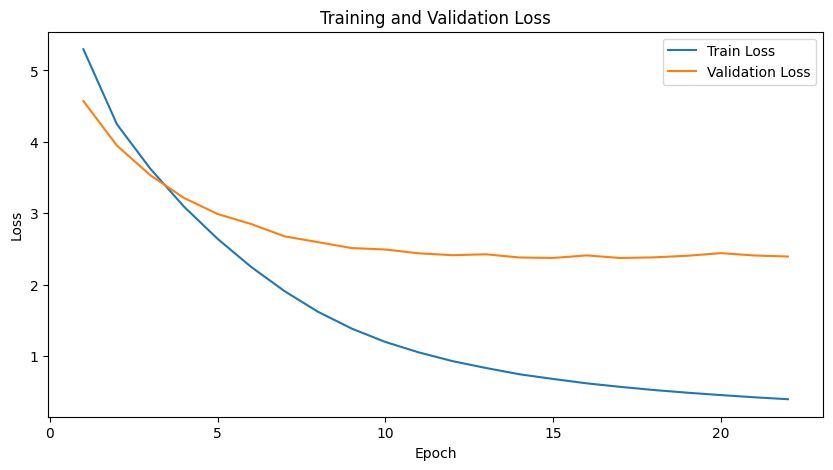

Loss plot saved to /content/drive/MyDrive/output_transformer_word/transformer_loss_plot_char.png.


In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.savefig(LOSS_PLOT_PATH)
plt.show()
print(f'Loss plot saved to {LOSS_PLOT_PATH}.')

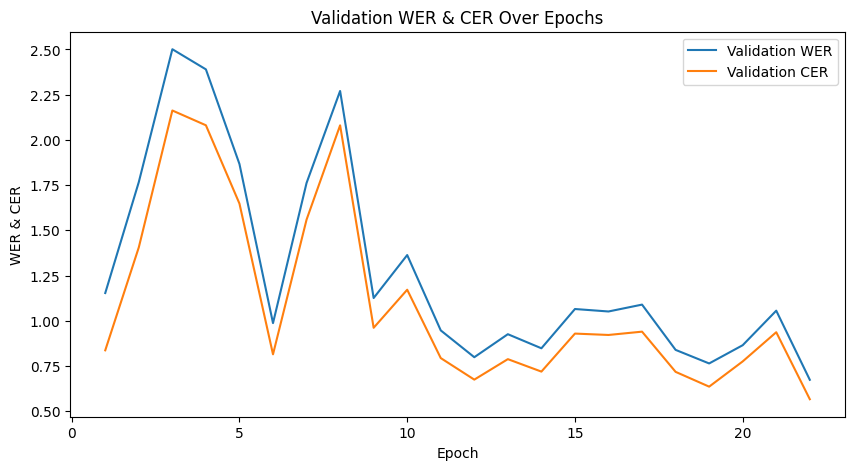

Plot saved to /content/drive/MyDrive/output_transformer_word/er_plot.png.


In [ ]:
# Plot validation CER & WER over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(valid_wers) + 1), valid_wers, label='Validation WER')
plt.plot(range(1, len(valid_cers) + 1), valid_cers, label='Validation CER')
plt.xlabel('Epoch')
plt.ylabel('WER & CER')
plt.legend()
plt.title('Validation WER & CER Over Epochs')
plt.savefig(ER_PLOT_PATH)

plt.show()
print(f'Plot saved to {ER_PLOT_PATH}.')

In [ ]:
def greedy_decode_inference(model, src, src_mask, max_len, bos_idx):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)
    src_padding_mask = (src == PAD_IDX)

    memory = model.encode(src, src_mask, src_key_padding_mask=src_padding_mask)

    ys = torch.ones(1, 1).fill_(bos_idx).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        tgt_mask = generate_square_subsequent_mask(ys.size(1)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask, tgt_key_padding_mask=None, memory_key_padding_mask=src_padding_mask)
        out = out.transpose(0,1)
        prob = model.generator(out[:, -1])
        next_word = torch.argmax(prob, dim=1).item()
        ys = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
        if next_word == EOS_IDX:
            break
    return ys

In [ ]:
def translate_sentence(sentence, model, word2idx, idx2word, device, max_len=MAX_LEN, decoding_strategy='greedy'):
    model.eval()
    tokens = tokenize(sentence)
    tokens = [BOS_IDX] + [word2idx.get(w, UNK_IDX) for w in tokens] + [EOS_IDX]
    tokens = tokens[:max_len]
    src = torch.tensor(tokens, dtype=torch.long).unsqueeze(0).to(device)
    src_mask = torch.zeros((src.shape[1], src.shape[1]), device=device).float()

    if decoding_strategy == 'greedy':
        tgt_tokens = greedy_decode_inference(model, src, src_mask, max_len, BOS_IDX).flatten()
    else:
        raise ValueError("Invalid decoding strategy")
    tgt_tokens = tgt_tokens.cpu().numpy()
    # Remove BOS token
    tgt_tokens = tgt_tokens[1:]
    # Stop at EOS token
    if EOS_IDX in tgt_tokens:
        eos_index = np.where(tgt_tokens == EOS_IDX)[0][0]
        tgt_tokens = tgt_tokens[:eos_index]
    translation = ' '.join([idx2word.get(idx, '') for idx in tgt_tokens if idx not in [PAD_IDX, BOS_IDX, EOS_IDX, UNK_IDX]])
    return translation

In [ ]:
def evaluate_and_save(model, df, src_sequences, trg_sequences, word2idx, idx2word, file_name):
    model.eval()
    predictions = []
    cer_scores = []
    wer_scores = []

    for src_ids, trg_ids in tqdm(zip(src_sequences, trg_sequences), total=len(src_sequences), desc=f'Evaluating {file_name}'):
        src_sentence = ' '.join([idx2word.get(idx, '') for idx in src_ids if idx not in [BOS_IDX, EOS_IDX, PAD_IDX]])
        trg_sentence = ' '.join([idx2word.get(idx, '') for idx in trg_ids if idx not in [BOS_IDX, EOS_IDX, PAD_IDX]])

        pred_sentence = translate_sentence(src_sentence, model, word2idx, idx2word, DEVICE)
        predictions.append(pred_sentence)
        cer_score = cer(trg_sentence, pred_sentence)
        wer_score = wer(trg_sentence, pred_sentence)
        cer_scores.append(cer_score)
        wer_scores.append(wer_score)

    results_df = pd.DataFrame({
        'Source': df['inFormalForm'],
        'Target': df['FormalForm'],
        'Prediction': predictions,
        'CER': cer_scores,
        'WER': wer_scores
    })

    results_df = results_df.sort_values(by=['CER', 'WER'], ascending=[True, True])

    results_path = os.path.join(OUTPUT_DIR, file_name)
    results_df.to_csv(results_path, index=False)
    avg_cer = np.mean(cer_scores)
    avg_wer = np.mean(wer_scores)
    print(f'Results saved to {results_path}')
    print(f'Average CER: {avg_cer:.4f}')
    print(f'Average WER: {avg_wer:.4f}')
    return results_df

In [ ]:
model.load_state_dict(torch.load(BEST_MODEL_PATH))
print('Best model loaded.')

print('Evaluating on training data...')
train_results = evaluate_and_save(model, train_df, train_src, train_trg, word2idx, idx2word, 'train_results_word_transformer.csv')

print('Evaluating on validation data...')
val_results = evaluate_and_save(model, val_df, val_src, val_trg, word2idx, idx2word, 'val_results_word_transformer.csv')

print('Evaluating on test data...')
test_results = evaluate_and_save(model, test_df, test_src, test_trg, word2idx, idx2word, 'test_results_word_transformer.csv')

Best model loaded.
Evaluating on training data...


Evaluating train_results_word_transformer.csv: 100%|██████████| 40008/40008 [51:01<00:00, 13.07it/s]


Results saved to /content/drive/MyDrive/output_transformer_word/train_results_word_transformer.csv
Average CER: 0.1276
Average WER: 0.1529
Evaluating on validation data...


Evaluating val_results_word_transformer.csv: 100%|██████████| 5001/5001 [07:18<00:00, 11.40it/s]


Results saved to /content/drive/MyDrive/output_transformer_word/val_results_word_transformer.csv
Average CER: 0.5150
Average WER: 0.6339
Evaluating on test data...


Evaluating test_results_word_transformer.csv: 100%|██████████| 5002/5002 [07:10<00:00, 11.63it/s]


Results saved to /content/drive/MyDrive/output_transformer_word/test_results_word_transformer.csv
Average CER: 0.5047
Average WER: 0.6239


In [ ]:
model.load_state_dict(torch.load(BEST_CER_MODEL_PATH))
print('Best CER model loaded.')

print('Evaluating on training data using best CER model...')
train_results = evaluate_and_save(model, train_df, train_src, train_trg, word2idx, idx2word, 'train_results_best_cer.csv')

print('Evaluating on validation data using best CER model...')
val_results = evaluate_and_save(model, val_df, val_src, val_trg, word2idx, idx2word, 'val_results_best_cer.csv')

print('Evaluating on test data using best CER model...')
test_results = evaluate_and_save(model, test_df, test_src, test_trg, word2idx, idx2word, 'test_results_best_cer.csv')

Best CER model loaded.
Evaluating on training data using best CER model...


Evaluating train_results_best_cer.csv:   0%|          | 0/40008 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6041: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(
Evaluating train_results_best_cer.csv: 100%|██████████| 40008/40008 [52:28<00:00, 12.71it/s]


Results saved to /content/drive/MyDrive/output_transformer_word/train_results_best_cer.csv
Average CER: 0.1040
Average WER: 0.1234
Evaluating on validation data using best CER model...


Evaluating val_results_best_cer.csv: 100%|██████████| 5001/5001 [07:12<00:00, 11.56it/s]


Results saved to /content/drive/MyDrive/output_transformer_word/val_results_best_cer.csv
Average CER: 0.4698
Average WER: 0.5893
Evaluating on test data using best CER model...


Evaluating test_results_best_cer.csv: 100%|██████████| 5002/5002 [07:11<00:00, 11.60it/s]


Results saved to /content/drive/MyDrive/output_transformer_word/test_results_best_cer.csv
Average CER: 0.4659
Average WER: 0.5810
